In [1]:
import math
import matplotlib.pyplot as plt
import torch

from azula.guidance import MMPSDenoiser
from azula.sample import LMSSampler, PCSampler
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_dataset
from lpdm.diffusion import get_autoencoder, get_denoiser
from lpdm.plot import animate_fields, draw_fields

plt.rcParams["animation.ffmpeg_path"] = "/mnt/sw/nix/store/fz8y69w4c97lcgv1wwk03bd4yh4zank7-ffmpeg-full-6.0-bin/bin/ffmpeg"  # fmt: off
plt.rcParams["animation.html"] = "html5"

_ = torch.manual_seed(0)

In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/pg5qkw4r_dit_large_False_adamw_0.0001_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}",
    split="test",
    steps=cfg.trajectory.length,
    dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [5]:
autoencoder = get_autoencoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.load_state_dict(torch.load(runpath / "autoencoder/state.pth", weights_only=True))
autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 64, eps=1e-05, affine=False)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1-2): 2 x ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 128, eps=1e-05, affine=False)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )

## Denoiser

In [6]:
shape = (cfg.ae.lat_channels, cfg.trajectory.length, 64, 64)
denoiser = get_denoiser(
    shape=shape,
    label_features=testset.metadata.n_constant_scalars,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state_ema.pth", weights_only=True))
denoiser.cuda()
denoiser.eval()

PreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): DiT(
        (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=2, w=2)
        (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=2, w=2)
        (in_proj): Linear(in_features=16, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=16, bias=True)
        (positional_embedding): Sequential(
          (0): Linear(in_features=3, out_features=1024, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (blocks): ModuleList(
          (0-15): 16 x DiTBlock(
            (norm): LayerNorm(dim=-1)
            (ada_zero): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
              (1): SiLU()
              (2): Linear(in_features=256, out_features=6144, bias=True)
              (3): Rearrange('... (n C

In [7]:
sum(p.numel() for p in denoiser.parameters())

228920080

## Evaluation

In [8]:
sampler = LMSSampler(denoiser, steps=64).to(device)

label = torch.tensor([1.13]).to(device)

z1 = sampler.init((1, math.prod(shape)))
z0 = sampler(z1, label=label)
z0 = z0.reshape((1, *shape))

with torch.no_grad():
    x = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)
    x = rearrange(x, "1 C L H W -> L H W C").cpu()

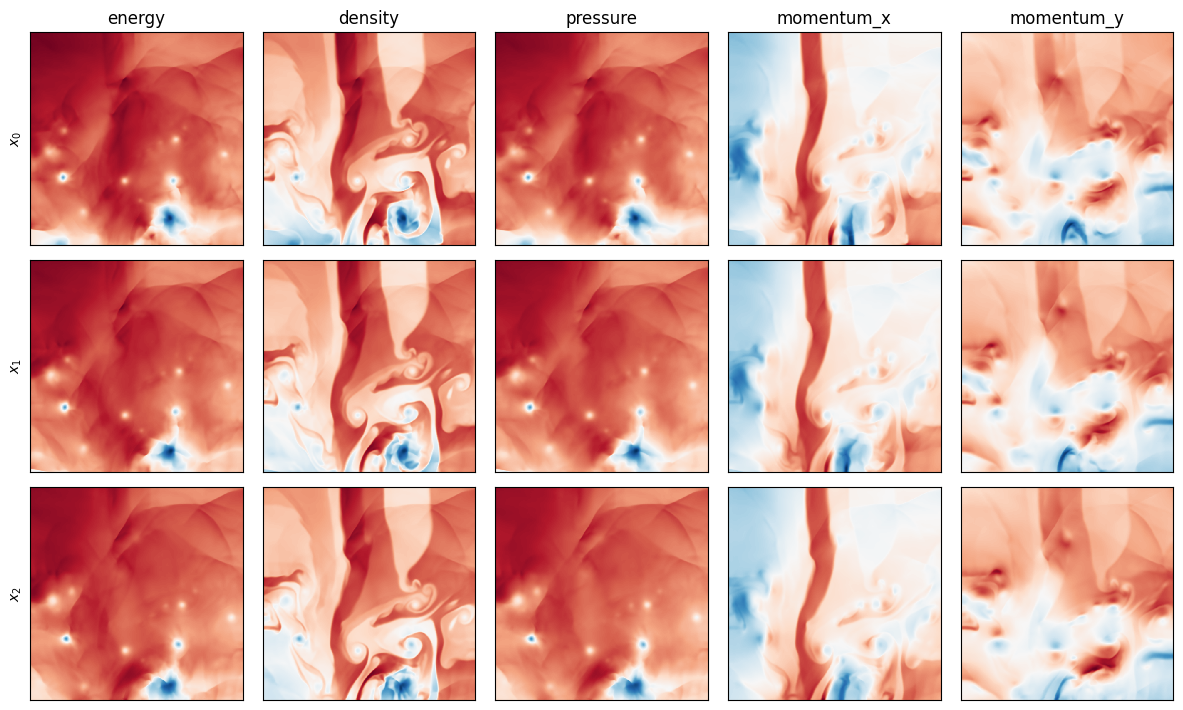

In [9]:
fig = draw_fields(x, fields=cfg.dataset.fields)

## Condition

In [10]:
item = testset[13]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> 1 C L H W")

label = item["constant_scalars"].to(device)

with torch.no_grad():
    z = torch.vmap(autoencoder.encode, in_dims=2, out_dims=2)(x)

x = rearrange(x, "1 C L H W -> L H W C").cpu()

In [11]:
def A(z):
    return z.reshape(shape)[:, 0, :, :].reshape(-1)


def infer(A, y):
    cond_denoiser = MMPSDenoiser(
        denoiser,
        A=A,
        y=y,
        var_y=1e-6,
        iterations=3,
    )

    cond_sampler = PCSampler(cond_denoiser, steps=64, corrections=1, delta=0.1).to(device)

    z1 = cond_sampler.init((1, math.prod(shape)))
    z0 = cond_sampler(z1, label=label)
    z0 = z0.reshape((1, *shape))

    with torch.no_grad():
        x_hat = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)

    x_hat = rearrange(x_hat, "1 C L H W -> L H W C").cpu()

    return x_hat, z0

In [12]:
x_hat, z_hat = infer(A, A(z))

In [13]:
animation = animate_fields(x, x_hat, fields=cfg.dataset.fields)
animation.save("conditional.mp4", dpi=300, writer="ffmpeg")

display(animation)

plt.close()

## Rollout

In [14]:
rollout_length = 9
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}",
    split="test",
    steps=rollout_length,
    dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

In [15]:
item = testset[13]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> 1 C L H W")

label = item["constant_scalars"].to(device)

with torch.no_grad():
    z = torch.vmap(autoencoder.encode, in_dims=2, out_dims=2)(x)

x = rearrange(x, "1 C L H W -> L H W C").cpu()

In [16]:
y = z[..., :, 0, :, :].reshape(-1)

trajectory = []

while len(trajectory) < rollout_length:
    x_hat, z_hat = infer(A, y)

    if trajectory:
        trajectory.extend(x_hat[1:].unbind(0))
    else:
        trajectory.extend(x_hat.unbind(0))

    y = z_hat[..., :, -1, :, :].reshape(-1)

x_hat = torch.stack(trajectory)

In [17]:
animation = animate_fields(x, x_hat, fields=cfg.dataset.fields)
animation.save("rollout.mp4", dpi=300, writer="ffmpeg")

display(animation)

plt.close()